# Final Project 3. EDA.

In [177]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from sklearn import preprocessing, neighbors, grid_search, tree, ensemble, metrics, cross_validation, externals

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('ggplot')
from sklearn import linear_model

<i>Problem: I am still trying to predict if user becomes a paid customer based on his activity and Whil sign up info. </i>

<i>In order to create the dataset there was some SQL preprocessing done:
<ul>
<li>Removed users who didn't complete sign up, on-boarding, or spent less than 15 sec watching content</li>
<li>Removed corporate users and Whil internal users</li>
<li>Removed test users from the dataset</li>
<li>Counted the total amount of sessions and series completed for each user during the trial period</li>
<li>Counted the duration of all watched content for each user (during trial), transformed into seconds</li>
<li>Converted experience level from json to text format.</li>
</ul></i>


<i>Note: I updated the data dictionary in final project 2.</i>

In [178]:
df = pd.read_csv(os.path.join('..', 'Dataset', 'QueryResults.csv'))

df.head()

,user_id,sec,sessions_completed,series_completed,gender,experience_level,estimate_birth_day,focus,subscribed
0,16,225,1,0,m,low,1982-03-14 04:32:24.435+00,mindfulness,1.0
1,41,1795,1,0,f,medium,1969-04-21 13:25:48.392+00,yoga,NaN
2,104,3750,9,2,f,high,1958-04-24 20:23:59.469+00,mindfulness,1.0
3,131,635,2,0,f,medium,1968-04-27 23:50:42.827+00,mindfulness,NaN
4,155,810,4,0,f,high,1963-04-25 20:15:37.788+00,mindfulness,1.0


In [179]:
print 'Rows total: ', len(df)

Rows total:  18730


<h3><i>Missing data:</i></h3> 

In [180]:
df.isnull().sum()

user_id                   0
sec                       0
sessions_completed        0
series_completed          0
gender                    0
experience_level          0
estimate_birth_day    11753
focus                     0
subscribed            17593
dtype: int64

<h4><i>estimate_birth_day:</i></h4> 

In [181]:
print 'Rows total: ', len(df)
print 'Amount of users with missing DoB', df.estimate_birth_day.isnull().sum()
print 'Percent of users with missing DoB: ', df.estimate_birth_day.isnull().sum()*100/len(df)

Rows total:  18730
Amount of users with missing DoB 11753
Percent of users with missing DoB:  62


<i>Looks like I will not use estimate_birth_day.</i>

In [182]:
df.drop(['estimate_birth_day'], axis = 1, inplace = True)
df.head()

,user_id,sec,sessions_completed,series_completed,gender,experience_level,focus,subscribed
0,16,225,1,0,m,low,mindfulness,1.0
1,41,1795,1,0,f,medium,yoga,NaN
2,104,3750,9,2,f,high,mindfulness,1.0
3,131,635,2,0,f,medium,mindfulness,NaN
4,155,810,4,0,f,high,mindfulness,1.0


<h4><i>subscribed:</i></h4> 

In [183]:
df.subscribed.unique()

array([  1.,  nan,   0.])

<i>In fact all NaNs here are users that didn't sibscribe. 0s are users who subscribed but then cancelled subscription via support, and 1s are subscribed users. Let's turn them into a binary value.</i>

In [184]:
def subscribe(row):
    if row.subscribed == 1:
        return 1
    else:
        return 0
   
experience = df.apply(subscribe, axis = 1)

cat=experience.rename("subscribedYN")

df=df.join(cat)

In [185]:
df.drop(['subscribed'], axis = 1, inplace = True)
df.head()

,user_id,sec,sessions_completed,series_completed,gender,experience_level,focus,subscribedYN
0,16,225,1,0,m,low,mindfulness,1
1,41,1795,1,0,f,medium,yoga,0
2,104,3750,9,2,f,high,mindfulness,1
3,131,635,2,0,f,medium,mindfulness,0
4,155,810,4,0,f,high,mindfulness,1


In [186]:
print 'Total users subscribed: ', df.subscribedYN.sum()
print '% of subscribed users among all users:', df.subscribedYN.sum()*100.0/len(df)

Total users subscribed:  1099
% of subscribed users among all users: 5.86759209824


In [187]:
df.isnull().sum()

user_id               0
sec                   0
sessions_completed    0
series_completed      0
gender                0
experience_level      0
focus                 0
subscribedYN          0
dtype: int64

<h3><i> For better analysis, let's transform gender, experiense_level, focus into numeric values: </i></h3>

In [188]:
df.experience_level.unique()

array(['low', 'medium', 'high', 'none'], dtype=object)

In [189]:
def exp_lvl(row):
    if row.experience_level == 'none':
        return 0
    elif row.experience_level == 'low':
        return 1
    elif row.experience_level == 'medium':
        return 2
    else:
        return 3
   
experience = df.apply(exp_lvl, axis = 1)

cat=experience.rename("experience")

df=df.join(cat)  

In [190]:
df.focus.unique()

array(['mindfulness', 'yoga'], dtype=object)

In [191]:
def focus_n(row):
    if row.focus == 'yoga':
        return 1
    else:
        return 0
    
focus_n = df.apply(focus_n, axis = 1)

cat=focus_n.rename("focus_n")

df=df.join(cat)

In [192]:
df.gender.unique()

array(['m', 'f'], dtype=object)

In [193]:
def gender_n(row):
    if row.gender == 'm':
        return 1
    else:
        return 0
    
focus_n = df.apply(gender_n, axis = 1)

cat=focus_n.rename('gender_n')

df=df.join(cat)

In [194]:
df.columns

Index([u'user_id', u'sec', u'sessions_completed', u'series_completed',
       u'gender', u'experience_level', u'focus', u'subscribedYN',
       u'experience', u'focus_n', u'gender_n'],
      dtype='object')

<h3><i>Let's drop old columns, and also user_id column, we don't need it. And let's change the order of columns.</i></h3>

In [195]:
df = df[['sec','sessions_completed','series_completed','experience','focus_n','gender_n','subscribedYN']]

In [196]:
df.head()

,sec,sessions_completed,series_completed,experience,focus_n,gender_n,subscribedYN
0,225,1,0,1,0,1,1
1,1795,1,0,2,1,0,0
2,3750,9,2,3,0,0,1
3,635,2,0,2,0,0,0
4,810,4,0,3,0,0,1


<h3><i>Plots and summary: </i></h3>

In [198]:
df.describe()

,sec,sessions_completed,series_completed,experience,focus_n,gender_n,subscribedYN
count,18730.000000,18730.000000,18730.000000,18730.000000,18730.000000,18730.000000,18730.000000
mean,1187.645489,4.660812,0.094447,1.104004,0.102776,0.357501,0.058676
std,2233.733290,6.087137,0.772198,0.919802,0.303675,0.479277,0.235023
min,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,480.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1260.000000,5.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,57985.000000,146.000000,35.000000,3.000000,1.000000,1.000000,1.000000


<h4><i>Boxplots:</i></h4> 

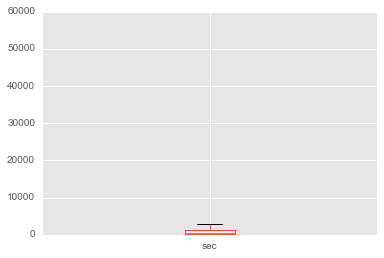

In [199]:
df.sec.plot(kind = 'box')

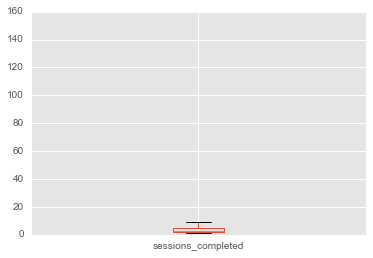

In [200]:
df.sessions_completed.plot(kind = 'box')

<i>Most of the users have very low activity.</i>

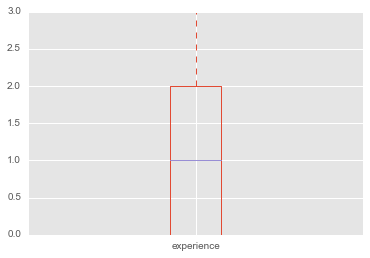

In [201]:
df.experience.plot(kind = 'box')

<h4><i>Plotting the histograms:</i></h4>

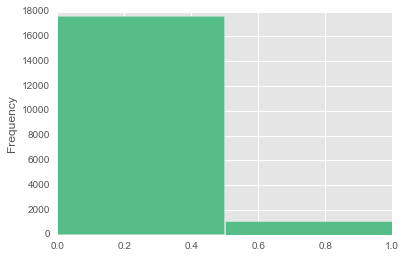

In [202]:
df.subscribedYN.plot(kind = 'hist', color='#55bd88', range = (0, 1), bins = 2)

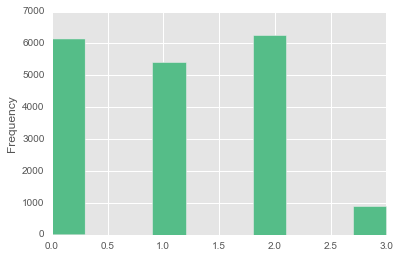

In [203]:
df.experience.plot(kind = 'hist', color='#55bd88')

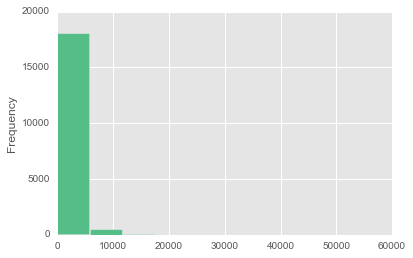

In [204]:
df.sec.plot(kind = 'hist', color='#55bd88')

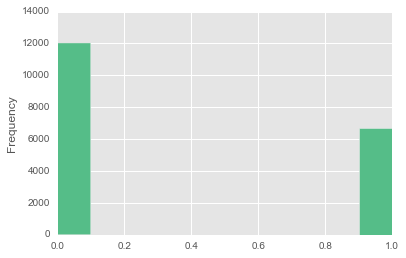

In [205]:
df.gender_n.plot(kind = 'hist', color='#55bd88')

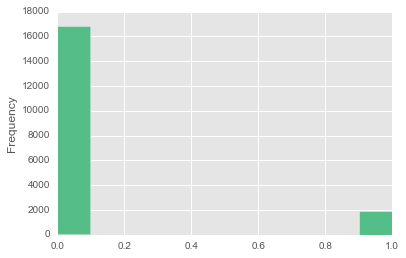

In [206]:
df.focus_n.plot(kind = 'hist', color='#55bd88')

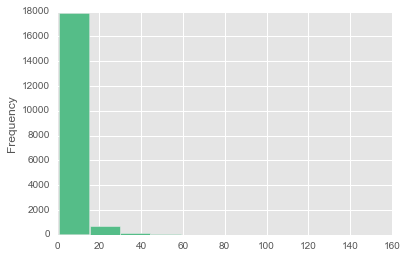

In [207]:
df.sessions_completed.plot(kind = 'hist', color='#55bd88')

<h4><i>Scatter matrix:</i></h4>

In [208]:
color = df.experience.map({3: 'red', 2: 'red', 1: 'green', 0: 'blue'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1352320d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1370cfc50>]], dtype=object)

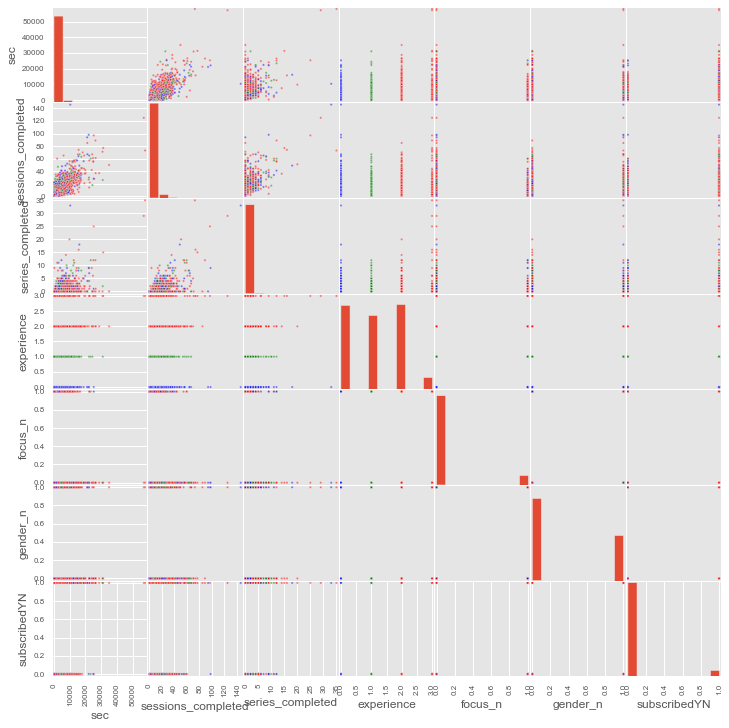

In [209]:
pd.tools.plotting.scatter_matrix(df, c = color, figsize=(12, 12))

<h3><i>Let's check data disctribution:</i></h3>

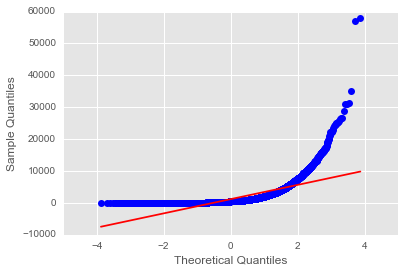

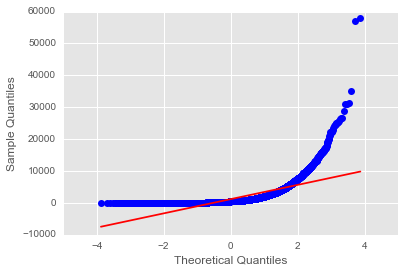

In [210]:
sm.qqplot(df.sec, line = 's')

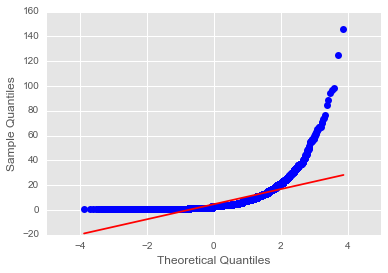

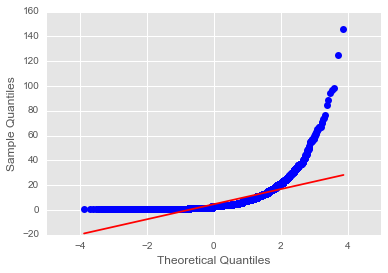

In [211]:
sm.qqplot(df.sessions_completed, line = 's')

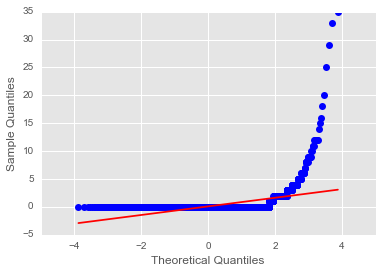

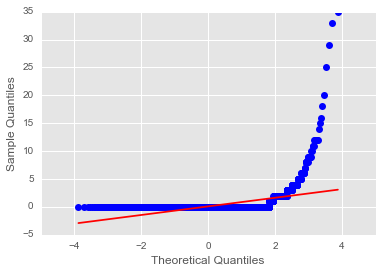

In [212]:
sm.qqplot(df.series_completed, line = 's')

<i>The data is not distributed normally, this is closer to exponential distribution. Most likely this is a result of the large amount of low values and some outliers with extremely high points.</i>

<h3><i>Summary</i></h3>

In [214]:
df.corr()

,sec,sessions_completed,series_completed,experience,focus_n,gender_n,subscribedYN
sec,1.000000,0.815377,0.485237,0.143535,0.016027,0.003248,0.459421
sessions_completed,0.815377,1.000000,0.552268,0.097124,-0.038563,0.018690,0.358653
series_completed,0.485237,0.552268,1.000000,0.039392,0.001637,-0.003956,0.192762
experience,0.143535,0.097124,0.039392,1.000000,0.152501,-0.016522,0.226416
focus_n,0.016027,-0.038563,0.001637,0.152501,1.000000,0.000664,0.050908
gender_n,0.003248,0.018690,-0.003956,-0.016522,0.000664,1.000000,-0.018436
subscribedYN,0.459421,0.358653,0.192762,0.226416,0.050908,-0.018436,1.000000


<i>Amount of seconds user spent watching content and sessions_completed are probably colinear. This makes sence, the more sessions a user watches, more time he/she spends watching content.</i>

<i>From the correlation table, subscribtion depends on amount of time(sec) that user spends watching content within trial period. I will use this feature for building a model. 
Also, my hypothesis is still the same: the more experienced users are more likely to subscribe.</i>

<h3><i>At last. Maybe drop outliers? Let's try...</i></h3>

In [215]:
df_new = df

In [216]:
def drop_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', df.shape[0]

    Q1 = df.sec.quantile(.25)
    Q2 = df.sec.quantile(.5)
    Q3 = df.sec.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, 'sec'
    print '- Q2/Median  =', Q2, 'sec'
    print '- Q3         =', Q3, 'sec'

    df.drop(df[(df.sec < Q1 - 1.5 * IQR) | (df.sec > Q3 + 1.5 * IQR)].index, inplace = True)

    print '- n (after)  =', df.shape[0]

drop_outliers(df_new)

Dropping outliers
- n (before) = 18730
- Q1         = 130.0 sec
- Q2/Median  = 480.0 sec
- Q3         = 1260.0 sec
- n (after)  = 16808


In [217]:
df_new.shape

(16808, 7)

In [218]:
df_new.subscribedYN.sum()

442

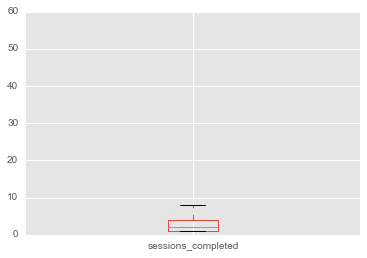

In [219]:
df_new.sessions_completed.plot(kind = 'box')

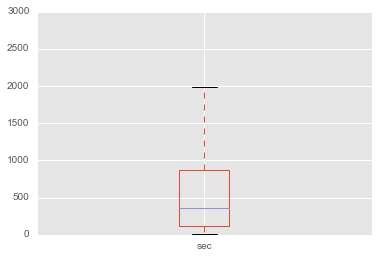

In [220]:
df_new.sec.plot(kind = 'box')

<i>After dropping the outliers I will get 442 subscribed users out of 16808, which is about 2.63% instead of 5.87% I had originally. I'm not sure that is enough observations of subscribed users to build a good model, I will keep them for now and, if needed, I will drop the outliers later.</i>